## Model Training Code

Setting basic import paths

In [27]:
# Add src to path to import xai_pkg
import sys
sys.path.append("../src")

data_path = "../data"
output_path = "../output"
metadata_path = f"{output_path}/models/model_metadata.json"
seed = 123

# Save outputs
save_outputs = True

# Setting standard figsize to export charts
fs = (15,7)

## 1. Load and inspect the loan data

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

df_train_full = pd.read_csv(f"{data_path}/raw/cs-training.csv")

with open(metadata_path, 'r') as f:
    config = json.load(f)


sample_mode = True
sample_frac = 1

if sample_frac == 1:
    sample_mode = False

config["sample_mode"] = sample_mode
config["sample_frac"] = sample_frac * 100

if sample_mode:
    df_train = df_train_full.sample(frac=sample_frac, random_state=seed)
else:
    df_train = df_train_full

# Drop ID column and add to metadata
config["dropped_columns"] = []

drop_cols = [
    'Unnamed: 0',  # Unnamed index column
]
for col in drop_cols:
    if col in df_train.columns:
        config["dropped_columns"].append(col)
        df_train.drop(columns=[col], inplace=True)

df_train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## 2. Exploratory Data Analysis

Reordering columns

In [29]:
df_train = df_train[[
    # Client information
    
    'age', 
    'NumberOfDependents',
    'MonthlyIncome', 
    'DebtRatio', 
    
    # Credit utilization
    'NumberOfOpenCreditLinesAndLoans', 
    'NumberRealEstateLoansOrLines',
    'RevolvingUtilizationOfUnsecuredLines',
    
    # Credit history
    'NumberOfTime30-59DaysPastDueNotWorse', 
    'NumberOfTime60-89DaysPastDueNotWorse', 
    'NumberOfTimes90DaysLate', 

    # Target variable (Y)
    'SeriousDlqin2yrs'
    ]]

In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   age                                   150000 non-null  int64  
 1   NumberOfDependents                    146076 non-null  float64
 2   MonthlyIncome                         120269 non-null  float64
 3   DebtRatio                             150000 non-null  float64
 4   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 5   NumberRealEstateLoansOrLines          150000 non-null  int64  
 6   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 7   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 9   NumberOfTimes90DaysLate               150000 non-null  int64  
 10  SeriousDlqin2yrs                      150000 non-null  int64  
dtype

In [31]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfDependents,146076.0,0.757222,1.115086,0.0,0.000000,0.000000,1.000000,20.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0


### 2.1 Missing values analysis

In [32]:
df_train.isnull().sum() / len(df_train)

age                                     0.000000
NumberOfDependents                      0.026160
MonthlyIncome                           0.198207
DebtRatio                               0.000000
NumberOfOpenCreditLinesAndLoans         0.000000
NumberRealEstateLoansOrLines            0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfTimes90DaysLate                 0.000000
SeriousDlqin2yrs                        0.000000
dtype: float64

In [33]:
# Check debt ratio for missing monthly income vs. rest of the dataset

# Check debt ratio for missing monthly income
print("\nMissing monthly income")
print(df_train[df_train["MonthlyIncome"].isna()]["DebtRatio"].describe())

# Check debt ratio for rest of the dataset
print("\nRest of the dataset")
print(df_train[~df_train["MonthlyIncome"].isna()]["DebtRatio"].describe())



Missing monthly income
count     29731.000000
mean       1673.396556
std        4248.372895
min           0.000000
25%         123.000000
50%        1159.000000
75%        2382.000000
max      329664.000000
Name: DebtRatio, dtype: float64

Rest of the dataset
count    120269.000000
mean         26.598777
std         424.446457
min           0.000000
25%           0.143388
50%           0.296023
75%           0.482559
max       61106.500000
Name: DebtRatio, dtype: float64


### Impute missing income and recalculate the debt ratio for the missing columns

In [34]:
from xai_pkg.model_training.preprocessing import impute_income, recalculate_debt_ratio

# Impute missing monthly incomes and recalculate debt ratio
df_train = impute_income(
    df_train,
    income_col = "MonthlyIncome",
    add_flag=True)
df_train = recalculate_debt_ratio(
    df_train,
    debt_ratio_col = "DebtRatio",
    income_col = "MonthlyIncome"
)

# Check if imputed income is True for any row
print(df_train["imputed_income"].value_counts())
display(df_train[df_train["imputed_income"] == True].describe().T)


imputed_income
0.0    118635
1.0     31365
Name: count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
age,31365.0,55.944269,15.608183,21.0,45.000000,57.000000,67.000000,109.000000
NumberOfDependents,27441.0,0.340986,0.842831,0.0,0.000000,0.000000,0.000000,10.000000
MonthlyIncome,31365.0,5437.000000,0.000000,5437.0,5437.000000,5437.000000,5437.000000,5437.000000
DebtRatio,31365.0,0.306823,0.769904,0.0,0.022439,0.210410,0.436454,60.633438
NumberOfOpenCreditLinesAndLoans,31365.0,7.208034,4.843125,0.0,4.000000,6.000000,10.000000,45.000000
NumberRealEstateLoansOrLines,31365.0,0.863415,1.028463,0.0,0.000000,1.000000,1.000000,23.000000
RevolvingUtilizationOfUnsecuredLines,31365.0,6.526814,214.688501,0.0,0.016279,0.082731,0.442353,22198.000000
NumberOfTime30-59DaysPastDueNotWorse,31365.0,0.580743,6.263770,0.0,0.000000,0.000000,0.000000,98.000000
NumberOfTime60-89DaysPastDueNotWorse,31365.0,0.453563,6.250769,0.0,0.000000,0.000000,0.000000,98.000000
NumberOfTimes90DaysLate,31365.0,0.484680,6.258997,0.0,0.000000,0.000000,0.000000,98.000000


In [35]:
print("Total number of rows:", df_train.shape[0])

Total number of rows: 150000


### 2.2 Value Distributions

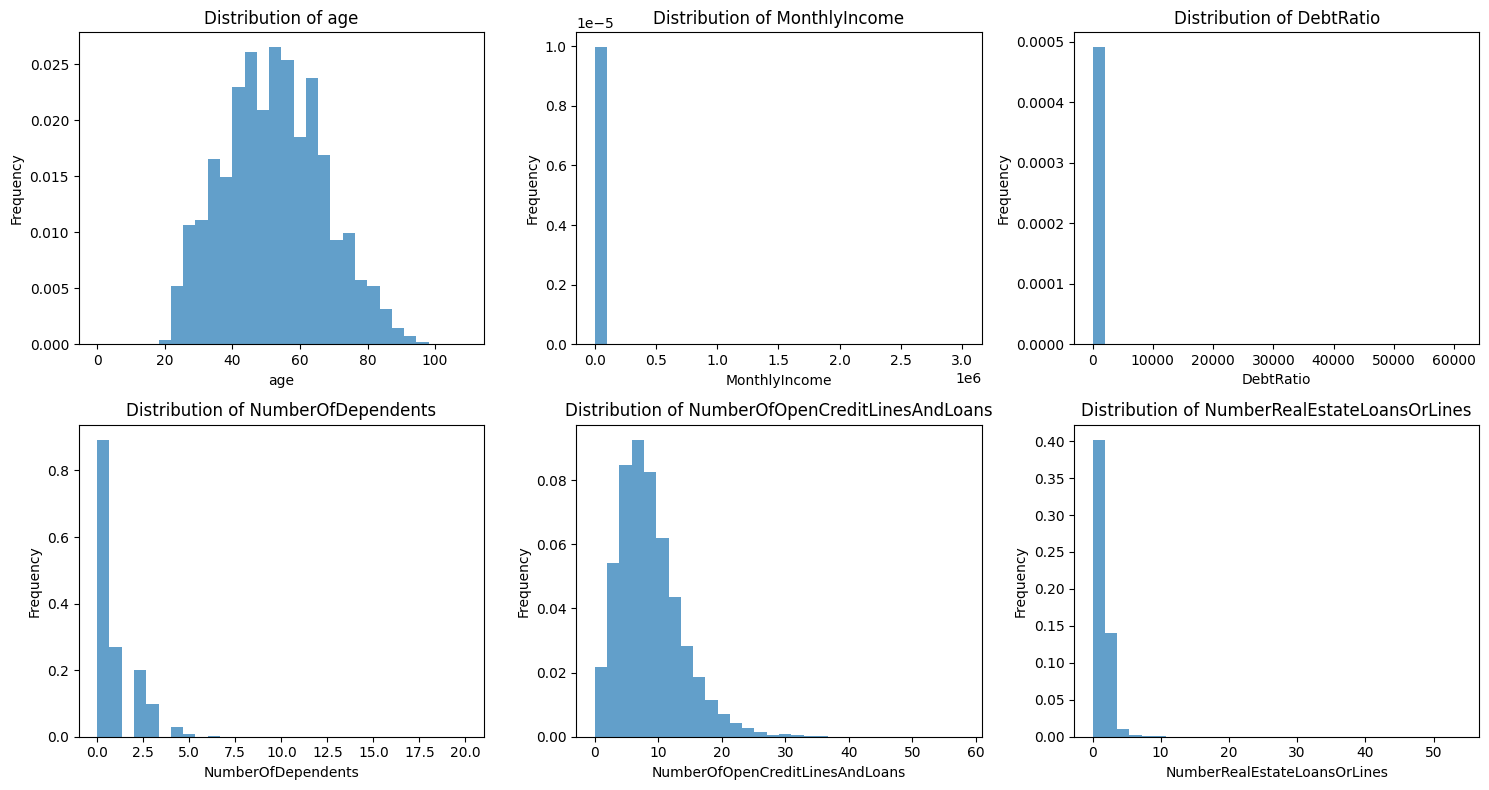

In [36]:
import matplotlib.pyplot as plt
# Assigning columns to analyze the distribution for

dist_cols = [
    'age',
    'MonthlyIncome',
    'DebtRatio',
    'NumberOfDependents',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberRealEstateLoansOrLines',
]

# Create dynamic histograms in one plot for each column in dist_cols; if features are more than 3, create a new row for every 3 features

len(dist_cols)

if len(dist_cols) <= 3:
    nrows = 1
else:
    nrows = len(dist_cols) // 3 + (len(dist_cols) % 3 > 0)

fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 4 * nrows))
for i, col in enumerate(dist_cols):
    ax = axes[i // 3, i % 3] if nrows > 1 else axes[i]
    plt.sca(ax)
    plt.hist(df_train[col], bins=30, alpha=0.7, density=True)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

# Adjust layout to prevent overlapping
plt.tight_layout()


### 2.3 Target distribution

Positive class weight: 0.07
Negative class weight: 0.93
Scale for positive class: 13.96


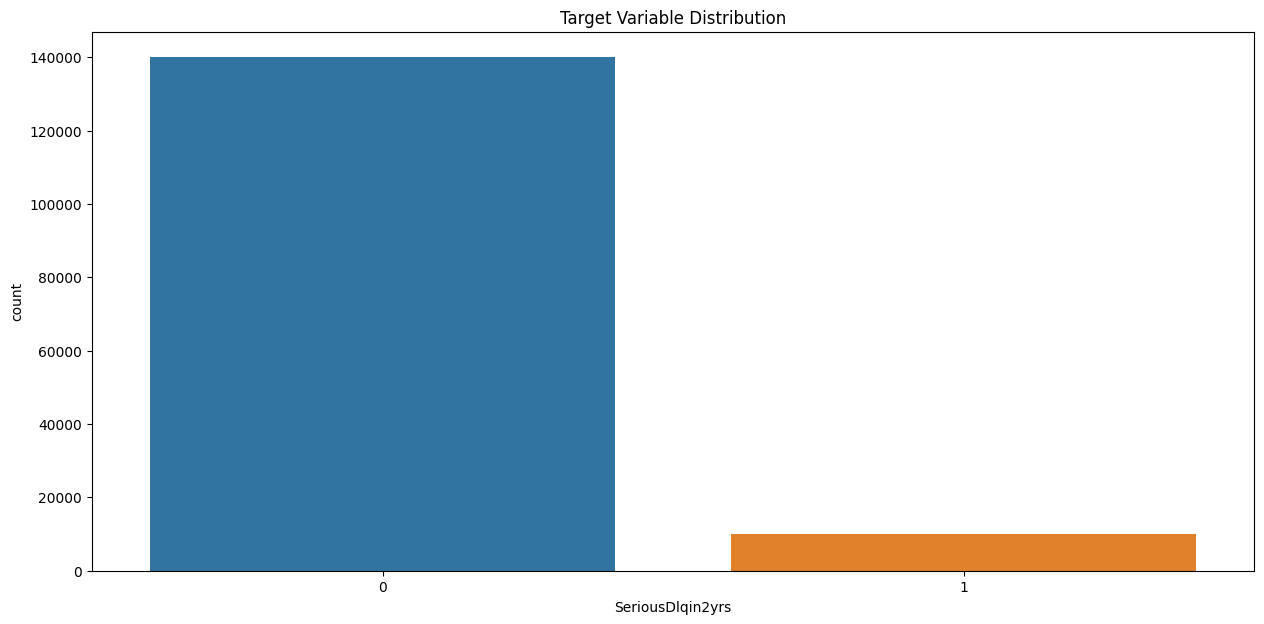

In [37]:
y = df_train['SeriousDlqin2yrs']
fig, ax = plt.subplots(figsize=fs)
sns.countplot(x=y, hue=y, legend=False)
plt.title('Target Variable Distribution')

# Target weight

pos_weight = y.mean()
neg_weight = 1 - pos_weight
scale_pos_weight = neg_weight / pos_weight

# Displaying the target weight
print(f"Positive class weight: {pos_weight:.2f}")
print(f"Negative class weight: {neg_weight:.2f}")
print(f"Scale for positive class: {scale_pos_weight:.2f}")

### 2.4 Target correlation plot

<class 'pandas.core.frame.DataFrame'>


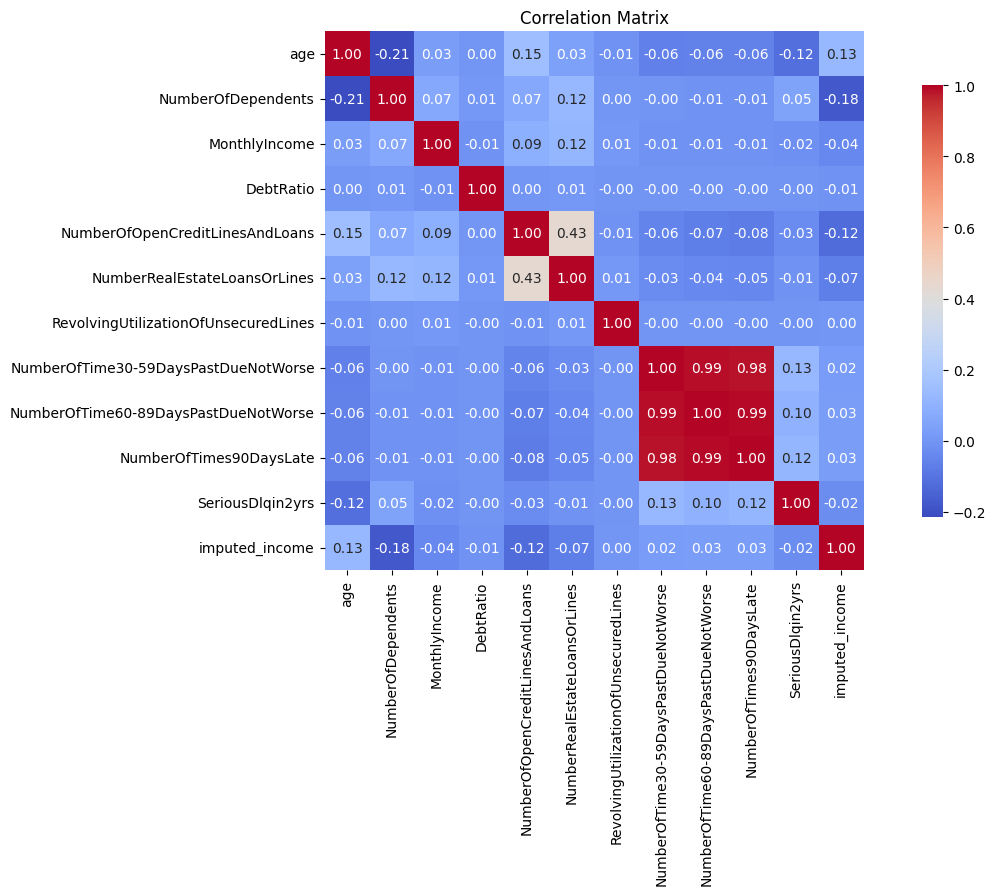

In [38]:
# Correlation matrix
print(type(df_train))
corr_matrix = df_train.corr()
fig, ax = plt.subplots(figsize=fs)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, ax=ax)
ax.set_title('Correlation Matrix')
# Save the correlation matrix plot
if save_outputs:
    plt.savefig(f"{output_path}/plots/correlation_matrix_pre_processing.png")

### 2.5 Deep-dive: Late payment variables

Evaluating the intercorrelation between the three late payment variables

/Users/timo/Documents/Thesis/xai-credit-decisions/.venv/lib/python3.10/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/Users/timo/Documents/Thesis/xai-credit-decisions/.venv/lib/python3.10/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/Users/timo/Documents/Thesis/xai-credit-decisions/.venv/lib/python3.10/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


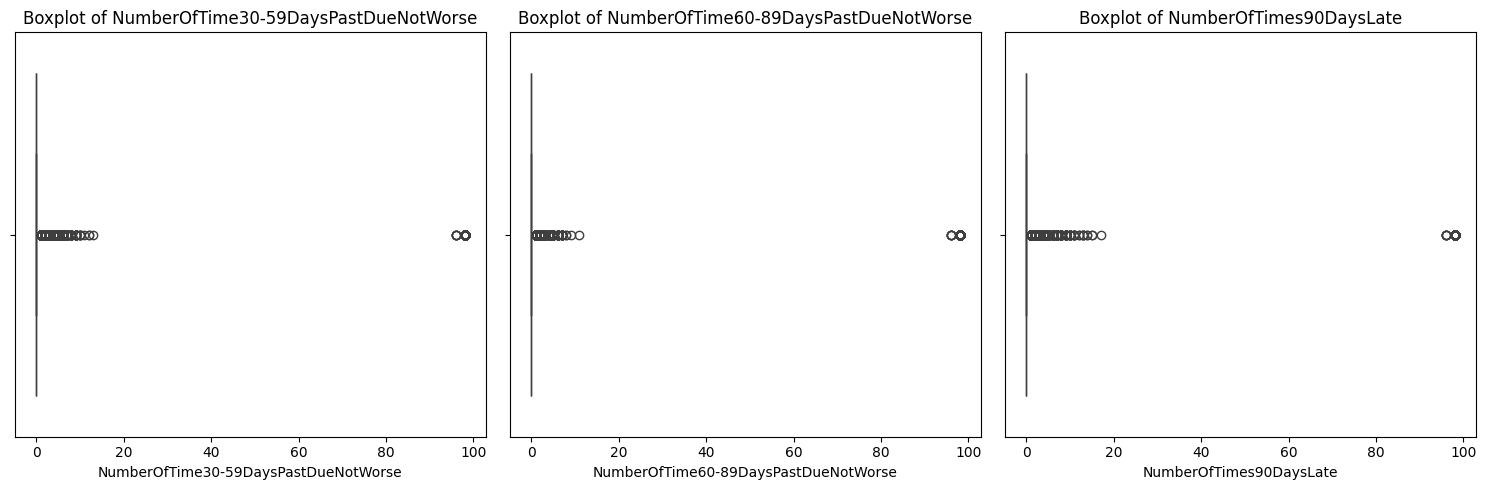

NumberOfTime30-59DaysPastDueNotWorse: 98
NumberOfTime60-89DaysPastDueNotWorse: 98
NumberOfTimes90DaysLate: 98


In [39]:
### Visualizing the data distribution of late variables incl. maximum values

late_vars = [
            "NumberOfTime30-59DaysPastDueNotWorse",
            "NumberOfTime60-89DaysPastDueNotWorse",
            "NumberOfTimes90DaysLate",
        ]

# Box plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, col in enumerate(late_vars):
    ax = axes[i]
    sns.boxplot(x=df_train[col], ax=ax)
    ax.set_title(f"Boxplot of {col}")
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()

# Print max values for each late variable
for col in late_vars:
    print(f"{col}: {df_train[col].max()}")

All late variables have a noticeable cluster of points around 96 and 98 which could be an error or earlier 0 value encoding. Since this leads to a high correlation among the late variables they are winsorized to the previous largest value in the next step

In [40]:

# Winsorizing late variables
from xai_pkg.model_training.preprocessing import winsorize_late_vars

df_train = winsorize_late_vars(df_train, late_vars = late_vars)

Check if the fix worked

/Users/timo/Documents/Thesis/xai-credit-decisions/.venv/lib/python3.10/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/Users/timo/Documents/Thesis/xai-credit-decisions/.venv/lib/python3.10/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/Users/timo/Documents/Thesis/xai-credit-decisions/.venv/lib/python3.10/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


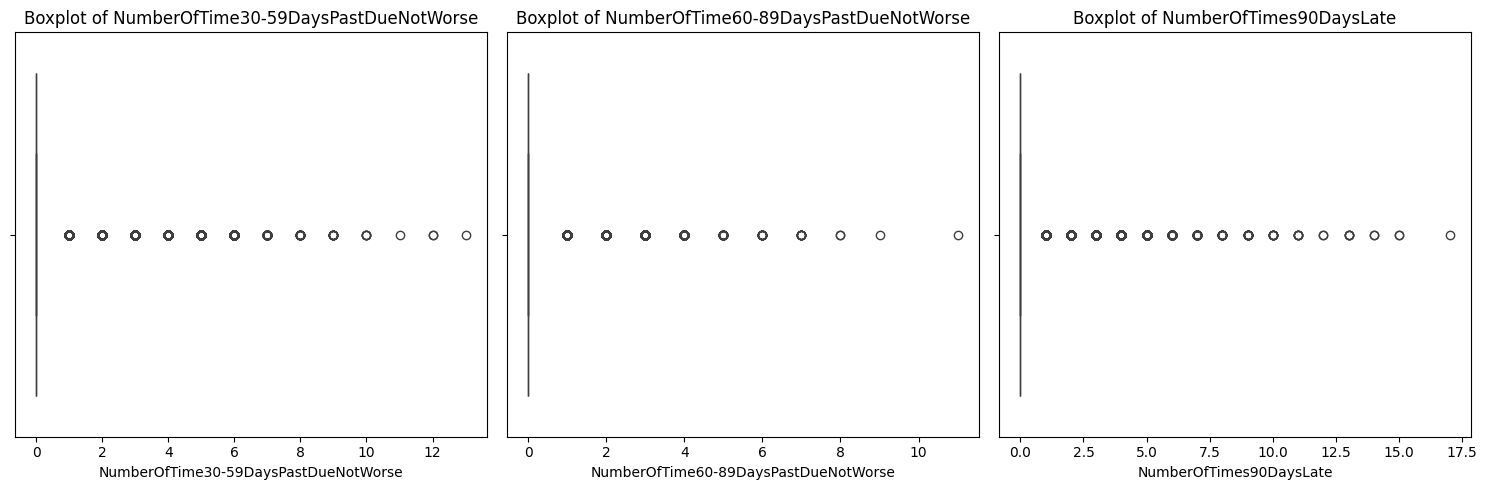

In [41]:
# Box plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, col in enumerate(late_vars):
    ax = axes[i]
    sns.boxplot(x=df_train[col], ax=ax)
    ax.set_title(f"Boxplot of {col}")
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()

## 3. Feature preprocessing & engineering
### 3.1 Adjust skewed features and trim outliers

In [42]:
# from xai_pkg.model_training.preprocessing import log_transform_features
from xai_pkg.model_training.preprocessing import trim_extreme_values

trim_dict = { 
    # Keys with tuples for (lower, upper) bounds
    'RevolvingUtilizationOfUnsecuredLines': (0, df_train['RevolvingUtilizationOfUnsecuredLines'].quantile(0.99)),
    'DebtRatio': (0, df_train['DebtRatio'].quantile(0.99)),
    'MonthlyIncome': (0, df_train['MonthlyIncome'].quantile(0.99))
}

config["trimmed_values"] = trim_dict

df_train = trim_extreme_values(
    data= df_train,
    trim_dict=trim_dict
) 

# log_scale_features = ['MonthlyIncome', 'DebtRatio']
# df_train = log_transform_features(df_train, log_scale_features, drop_features= True)

### 3.2 Calculate descriptive statistics for model metadata

In [43]:
# Calculate descriptive statistics for numeric features (after preprocessing)
# This will be stored in model metadata for consistent prediction preprocessing

desc_stats = {}
for col in df_train.select_dtypes(include=['int64', 'float64']).columns:
    if col != 'SeriousDlqin2yrs':  # Skip target column
        desc_stats[col] = {
            'mean': float(df_train[col].mean()),
            'median': float(df_train[col].median()),
            'std': float(df_train[col].std()),
            'min': float(df_train[col].min()),
            'max': float(df_train[col].max()),
            'count': int(df_train[col].count()),
            'q25': float(df_train[col].quantile(0.25)),
            'q75': float(df_train[col].quantile(0.75))
        }

# Add to config for later storage in metadata
config["descriptive_statistics"] = desc_stats

print("Calculated descriptive statistics for features:")
for feature, stats in desc_stats.items():
    print(f"  {feature}: median={stats['median']:.2f}, mean={stats['mean']:.2f}")

Calculated descriptive statistics for features:
  age: median=52.00, mean=52.30
  NumberOfDependents: median=0.00, mean=0.76
  MonthlyIncome: median=5437.00, mean=6209.01
  DebtRatio: median=0.28, mean=0.35
  NumberOfOpenCreditLinesAndLoans: median=8.00, mean=8.45
  NumberRealEstateLoansOrLines: median=1.00, mean=1.02
  RevolvingUtilizationOfUnsecuredLines: median=0.15, mean=0.32
  NumberOfTime30-59DaysPastDueNotWorse: median=0.00, mean=0.25
  NumberOfTime60-89DaysPastDueNotWorse: median=0.00, mean=0.06
  NumberOfTimes90DaysLate: median=0.00, mean=0.09
  imputed_income: median=0.00, mean=0.21


### Final feature correlation matrix & distribution

<class 'pandas.core.frame.DataFrame'>


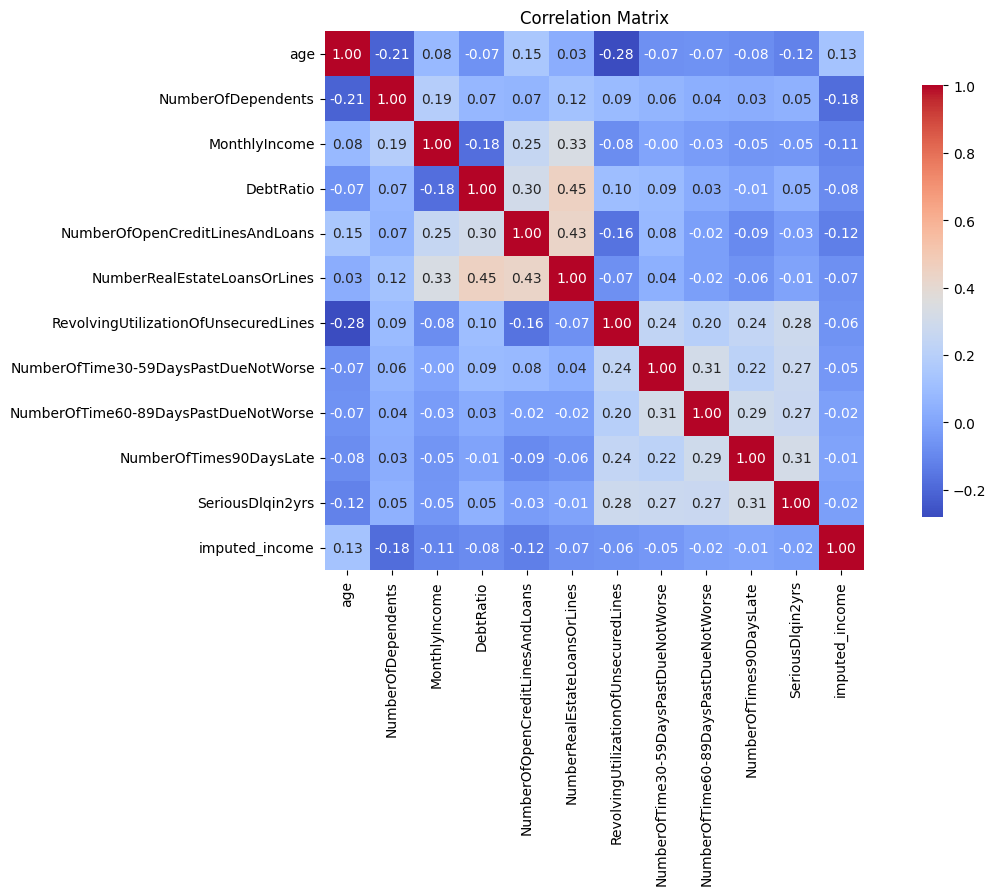

In [44]:
# Correlation matrix
print(type(df_train))
corr_matrix = df_train.corr()
fig, ax = plt.subplots(figsize=fs)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, ax=ax)
ax.set_title('Correlation Matrix')
# Save the correlation matrix plot
if save_outputs:
    plt.savefig(f"{output_path}/plots/correlation_matrix_post_processing.png")

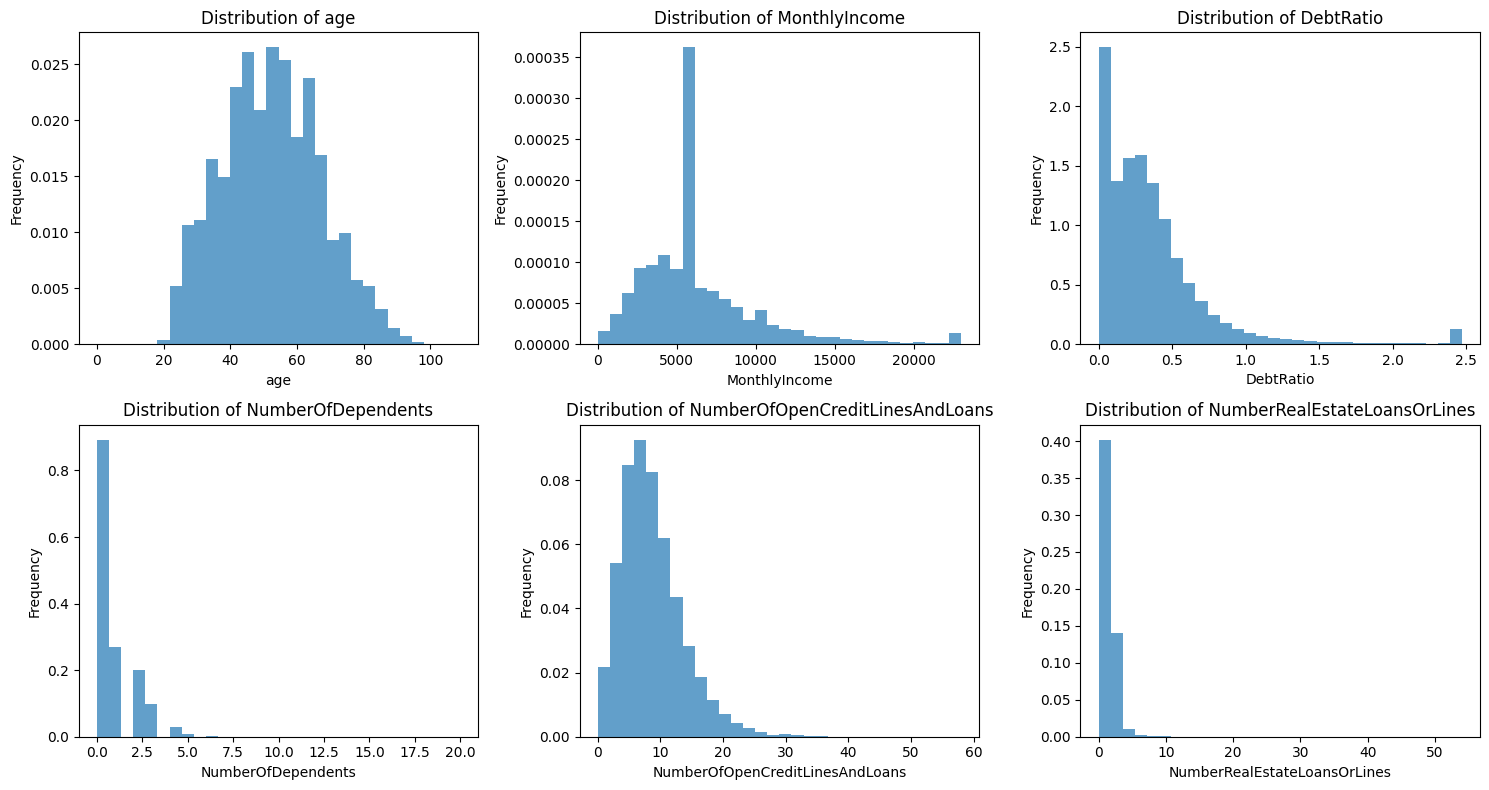

In [45]:
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 4 * nrows))
for i, col in enumerate(dist_cols):
    ax = axes[i // 3, i % 3] if nrows > 1 else axes[i]
    plt.sca(ax)
    plt.hist(df_train[col], bins=30, alpha=0.7, density=True)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

# Adjust layout to prevent overlapping
plt.tight_layout()


### 3.2 Split the data

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import numpy as np

# Splitting the data into training and testing sets

target = 'SeriousDlqin2yrs'

X = df_train.drop(columns=[target])
config["dropped_columns"].extend([target])
y = df_train[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

### 3.3 Undersample to improve class imbalance issues

In [47]:
from imblearn.under_sampling import RandomUnderSampler

undersampling_ratio = 0.3  # Undersample to 30% of the majority class

undersampler = RandomUnderSampler(
    sampling_strategy=undersampling_ratio, #type: ignore
    random_state=seed
)
resampled_result = undersampler.fit_resample(X_train, y_train)

X_train_undersampled, y_train_undersampled = resampled_result[0], resampled_result[1]

print(f"Applied undersampling: {len(y_train)} -> {len(y_train_undersampled)} samples")


# Store undersampled training data
if save_outputs:
    X_train_undersampled.to_csv(f"{data_path}/processed/X_train_undersampled.csv", index=False)
    y_train_undersampled.to_csv(f"{data_path}/processed/y_train_undersampled.csv", index=False)

Applied undersampling: 120000 -> 34757 samples


## 4. Model training
### 4.1 Setting up the pipeline for Optuna

In [48]:
%%time
import warnings
import numpy as np
from sklearn.metrics import recall_score, precision_score, make_scorer

# Suppress sklearn runtime warnings during hyperparameter tuning
warnings.filterwarnings('ignore', category=RuntimeWarning, module='sklearn')
np.seterr(divide='ignore', invalid='ignore', over='ignore')

from xai_pkg.model_training.tuning import tune_hyperparameters
from xai_pkg.model_training.preprocessing import get_preprocessor


preprocessor = get_preprocessor(
    X_train, 
    verbose=True,
)

models = [
    'LogisticRegression', 
    'RandomForest',
    'LightGBM',
    'XGBoost'
]

# Create custom score to weight recall with 70% and precision with 30%

def weighted_recall_precision(y_true, y_pred):
    recall = recall_score(y_true, y_pred, pos_label=1)
    precision = precision_score(y_true, y_pred, pos_label=1)
    return 0.7 * recall + 0.3 * precision

scoring_metric = make_scorer(weighted_recall_precision, greater_is_better=True)

print(f"\n🔍 Tuning model")

best_params, best_pipe, study = tune_hyperparameters(
    X_train = X_train_undersampled,
    y_train = y_train_undersampled,
    preprocessor=preprocessor,
    models=models,
    n_trials=100, 
    cv_folds=3, 
    scoring_metric=scoring_metric,
    obj_direction='maximize',
    random_state=seed,
    verbose=True
)

[I 2025-08-21 15:20:23,475] A new study created in memory with name: no-name-d46e695f-9ba7-4a1c-9f9e-375104f33bd2


Numeric features identified: ['age', 'NumberOfDependents', 'MonthlyIncome', 'DebtRatio', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines', 'RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'imputed_income']
Remaining features (not numeric): None

🔍 Tuning model


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-21 15:20:23,594] Trial 0 finished with value: 0.6793489313174031 and parameters: {'classifier': 'LogisticRegression', 'C': 0.7548764540205036, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 1729, 'tol': 5.679223741740072e-07}. Best is trial 0 with value: 0.6793489313174031.
[I 2025-08-21 15:20:25,243] Trial 1 finished with value: 0.6976703148076453 and parameters: {'classifier': 'LightGBM', 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.10451102732811947, 'n_estimators': 209, 'min_child_samples': 44, 'subsample': 0.9086682987290953, 'colsample_bytree': 0.8916535266016374, 'reg_lambda': 0.7224433825702216, 'reg_alpha': 0.3229589138531782}. Best is trial 1 with value: 0.6976703148076453.
[I 2025-08-21 15:20:25,835] Trial 2 finished with value: 0.7381280341084332 and parameters: {'classifier': 'XGBoost', 'max_depth': 3, 'learning_rate': 0.09121875250582216, 'n_estimators': 158, 'min_child_weight': 12, 'subsample': 0.8638745435443742, 'colsample_bytree': 0.84683918344

In [49]:
# Restore normal warning behavior
warnings.resetwarnings()
np.seterr(all='warn')

{'divide': 'ignore', 'over': 'ignore', 'under': 'warn', 'invalid': 'ignore'}

### 4.2 Evaluate best model

F1 Score: 0.2289
ROC AUC Score: 0.8646
Accuracy: 0.5871
Recall: 0.9172
Precision: 0.1308


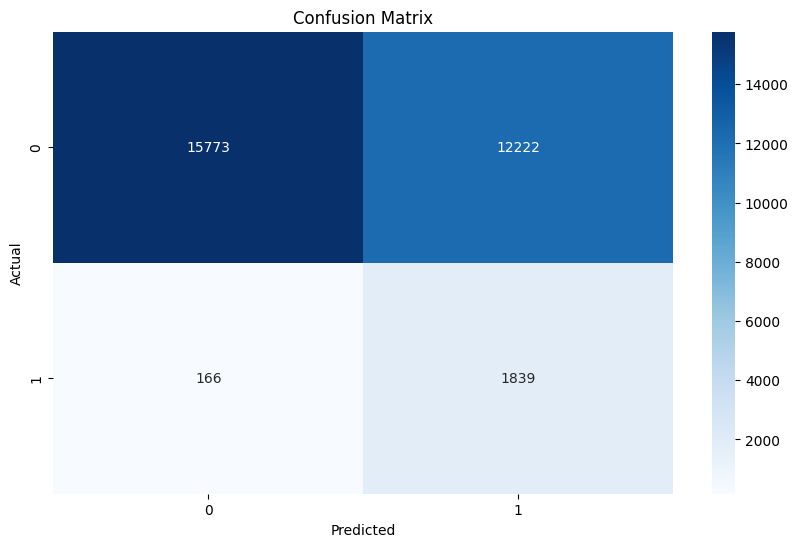

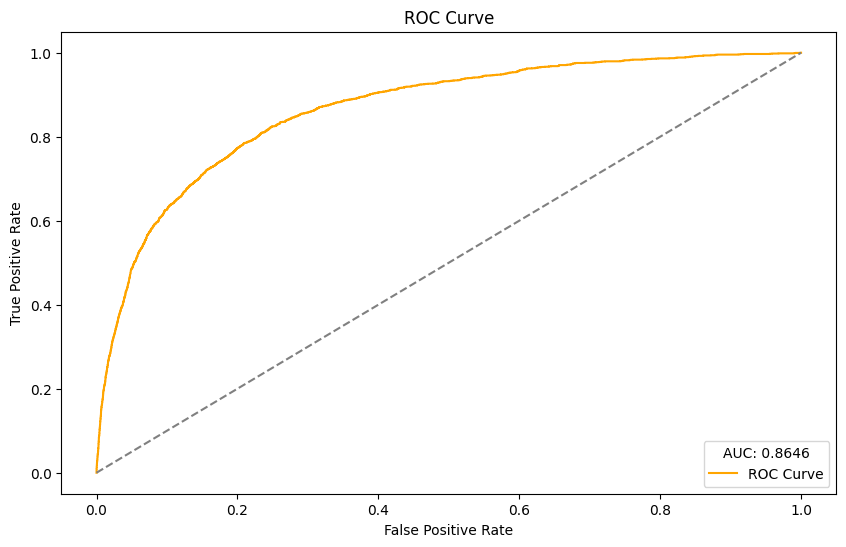

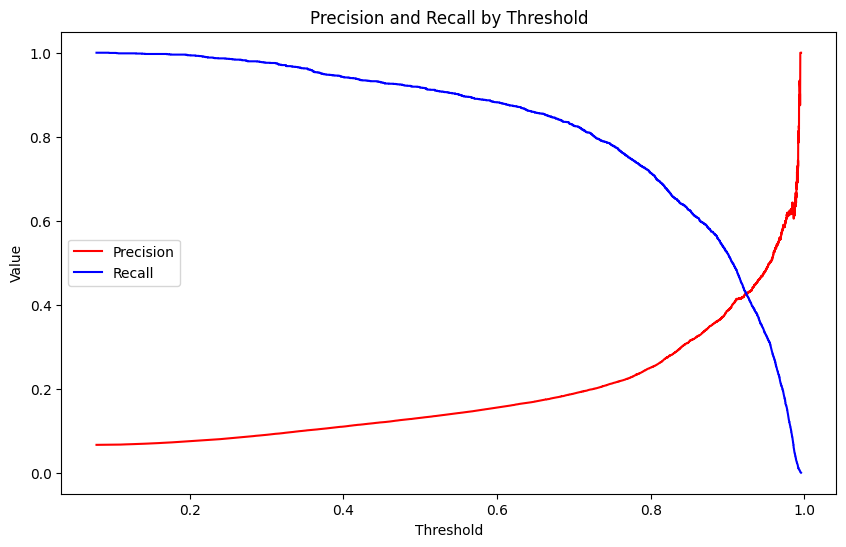

In [50]:

from xai_pkg.model_training.evaluation import evaluate_model

evaluate_model(
    best_pipe, # type: ignore
    X_test = X_val, 
    y_test = y_val,
    figsize = (10, 6),
    save_outputs = save_outputs,
    output_path = output_path
)

### 4.3 Save best model and model metadata

In [51]:
from datetime import datetime as dt
import joblib

# Save best model
if save_outputs:
    joblib.dump(best_pipe, f"{output_path}/models/best_model.pkl")

try:
    scoring_metric_text = str(scoring_metric)
except Exception as e:
    print(f"Error: {e}", "Using weighted 70% recall and 30% precision text")
    scoring_metric_text = "Weighted 70% recall and 30% precision"

model_metadata = {
    "model_type": best_params.get('classifier'),
    "random_state": seed,
    "sample_mode": config.get("sample_mode", False),
    "sample_frac": config.get("sample_frac", "100%"),
    "target": target,
    "best_params": best_params,
    "used_features": best_pipe.named_steps['preprocessor'].get_feature_names_out().tolist(),
    "log_scale_features": config.get("log_scale_features", []),
    "dropped_columns": config.get("dropped_columns", []),
    "late_vars": late_vars,
    "trimmed_values": config.get("trimmed_values", {}),
    "descriptive_statistics": config.get("descriptive_statistics", {}),
    "undersampling_ratio": undersampling_ratio,
    "train_set_shape": X_train_undersampled.shape,
    "test_set_shape": X_val.shape,
    "scoring_metric": "Weighted 70% recall and 30% precision",
    "cv_folds": 3,
    "last_updated": dt.now().isoformat(),
}

for k, v in model_metadata.items():
    if k != "descriptive_statistics":  # Don't print the full stats dict
        print(f"{k}: {v}")
    else:
        print(f"{k}: [stored {len(v)} feature statistics]")

if save_outputs:
    with open(metadata_path, "w") as f:
        json.dump(model_metadata, f, indent=2)

model_type: XGBoost
random_state: 123
sample_mode: False
sample_frac: 100
target: SeriousDlqin2yrs
best_params: {'classifier': 'XGBoost', 'max_depth': 3, 'learning_rate': 0.10684817765160132, 'n_estimators': 93, 'min_child_weight': 18, 'subsample': 0.8991441260731768, 'colsample_bytree': 0.8553202256307102, 'colsample_bylevel': 0.8921562730624304, 'gamma': 0.1017506745720127, 'reg_lambda': 0.10083741530245507, 'reg_alpha': 0.9633469115187149, 'scale_pos_weight': 9.978155793948272}
used_features: ['age', 'NumberOfDependents', 'MonthlyIncome', 'DebtRatio', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines', 'RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'imputed_income']
log_scale_features: []
dropped_columns: ['Unnamed: 0', 'SeriousDlqin2yrs']
late_vars: ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']
trimmed_value